# Ultimate Technologies Data Challenge

In [452]:
#Begin by importing essential libraries

import pandas as pd
import numpy as np
import json
import datetime
import time

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pylab import rcParams
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [453]:
logins = pd.read_json('Downloads/ultimate_challenge/logins.json')

with open('Downloads/ultimate_challenge/ultimate_data_challenge.json') as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [454]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


# Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [455]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [456]:
logins.shape[0] - logins.dropna().shape[0]

0

It seems there are no empty rows in our dataframe.

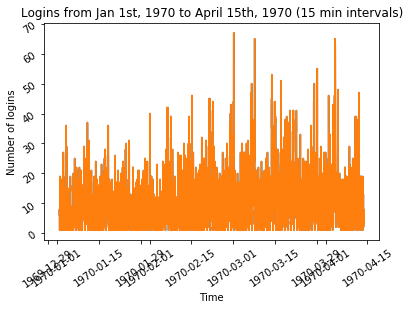

In [457]:
logins['rounded'] = logins['login_time'].dt.round('15min')
logins['year'] = logins['login_time'].dt.to_period('Y')
grouped = logins.groupby(['rounded']).count()

plt.plot(grouped)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins from Jan 1st, 1970 to April 15th, 1970 (15 min intervals)')
plt.show()


This plot gives the impression that login frequency is cyclic.  Let's examine a few months of data.

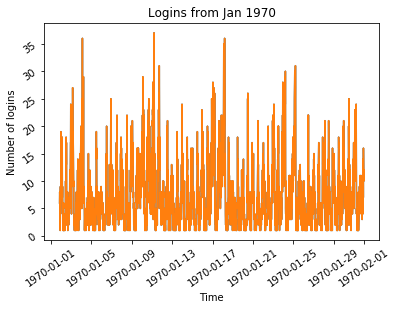

In [458]:
january = grouped[grouped.index < pd.to_datetime('1970-02-01')]
plt.plot(january)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins from Jan 1970')
plt.show()

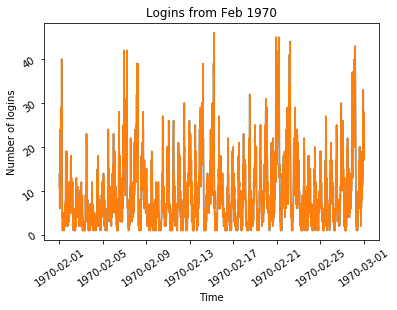

In [459]:
february = grouped[grouped.index < pd.to_datetime('1970-03-01')]
february = february[~february.index.isin(january.index)]
plt.plot(february)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins from Feb 1970')
plt.show()

Let's also select a few weeks to observe from this data set.  Representative weeks have been chosen arbitrarily and sliced to show data from Monday to Sunday.



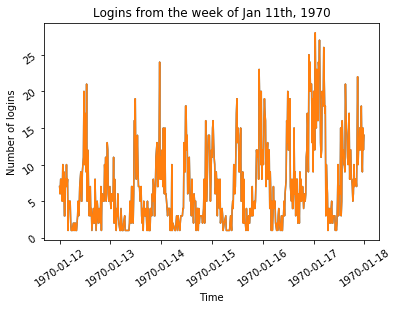

In [460]:
week1 = grouped[grouped.index < pd.to_datetime('1970-01-18')]
week1 = week1[week1.index >= pd.to_datetime('1970-01-12')]
plt.plot(week1)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins from the week of Jan 11th, 1970')
plt.show()

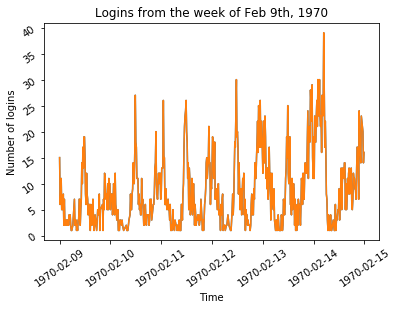

In [461]:
week2 = grouped[grouped.index < pd.to_datetime('1970-02-15')]
week2 = week2[week2.index >= pd.to_datetime('1970-02-09')]
plt.plot(week2)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins from the week of Feb 9th, 1970')
plt.show()

Right away, it is evident that daily cycles seem to exist, and that late Friday through early Saturday are the peak times.  Let's compare and contrast individual two-day cycles, chosen arbitrarily.

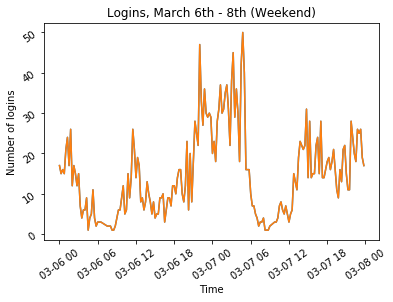

In [462]:
days1 = grouped[grouped.index < pd.to_datetime('1970-03-08')]
days1 = days1[days1.index >= pd.to_datetime('1970-03-06')]
plt.plot(days1)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins, March 6th - 8th (Weekend)')
plt.show()

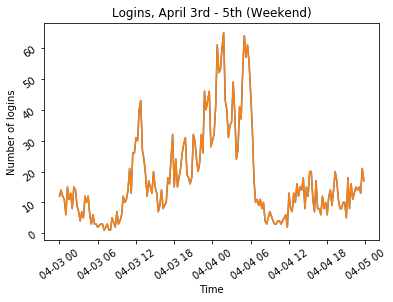

In [463]:
days2 = grouped[grouped.index < pd.to_datetime('1970-04-05')]
days2 = days2[days2.index >= pd.to_datetime('1970-04-03')]
plt.plot(days2)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins, April 3rd - 5th (Weekend)')
plt.show()

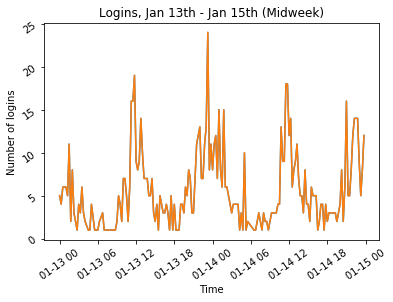

In [464]:
days3 = grouped[grouped.index < pd.to_datetime('1970-01-15')]
days3 = days3[days3.index >= pd.to_datetime('1970-01-13')]
plt.plot(days3)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins, Jan 13th - Jan 15th (Midweek)')
plt.show()

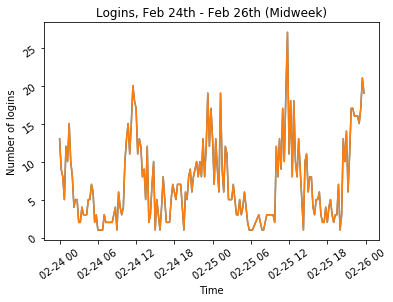

In [465]:
days4 = grouped[grouped.index < pd.to_datetime('1970-02-26')]
days4 = days4[days4.index >= pd.to_datetime('1970-02-24')]
plt.plot(days4)
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.tick_params(labelrotation = 35)
plt.title('Logins, Feb 24th - Feb 26th (Midweek)')
plt.show()

### Observations:

During the weekdays, period of higher activity are centered around noon and midnight.  Friday night into Saturday morning experiences the greatest activity, with sustaines logins near or above 20 logins every 15 minutes.  This is comparable to the peak login rate witnessed during many weekdays.

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

## Q: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Since the objective is to determine whether or not the new incentive has a significant impact on driver behavior, I would want to study the proportion of drivers serving both cities before and after the policy change. I could then perform a statistical  test, where the null hypothesis is that the two proportions are equal with an alternative hypothesis that the proportion of drivers serving both cities after the policy is higher than the proportion before the policy was enacted.

Such a test would provide an understanding of how significantly the policy affected driver behavior.

## Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:


## a. how you will implement the experiment


Data must first be produced which can identify which drivers are operating in both cities.  This is not evident from the present ultimate_challenge.json file.  However, since the file given to me contains aggregate datapoints for each driver, there must be trip-level data stored somewhere in the Ultimate Technologies database.  I would discuss obtaining this data with their IT department.

If there are no existing data to identify current usage of the toll bridge, I would recommend that the experiment be delayed until sufficient data exists as a control set, or until a cutoff date that can be specified by management.  I would also advocate that during the policy change, every driver must acknowledge the new procedure (conveniently through a google form or their app) to ensure compliance and adoption of the policy.

Whether the drivers crossed the bridge or not needs to be represented in the next version of the ultimate_challenge.json file, which I could obtain from the company's SQL database.

## b. what statistical test(s) you will conduct to verify the significance of theobservation


After another data collection period, I would evaluate the change by performing a one-tailed hypothesis test using a Z statistic and an alpha value of 0.05.  The results would argue for or against the proportion changing concurrently with the policy.

I could also run a bootstrap test, randomly generating samples of 10,000 drivers and detemining the distribution of sample proportions after the policy change.  This can be compared to the distribution of drivers before the policy change to see if it is comparable.  That is, do the proportion of drivers in the pre-policy data fall in the bottom 2.5% of bootstrap sample proportions?

## c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If the statistical tests suggest significant changes concurrent with policy change, I would suggest that the data supports their objective... more dirvers are traveling between the two cities.  

I would also discuss the results with the accounting branch of the company, to determine the cost of the policy and to uncover any changes in revenue in this time period.  If there were, I would see if they correlate with any increased avg_dist, surge_pct, and avg_serge, aggregated by date.  Closing the loop and documenting increased revenue is essential, and I would gladly provide the analysis if it isn't already being handled in accounting.



# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.


## 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [466]:
# Check for null entries

for column in df.columns:
    if df[df[column].isnull()].shape[0] != 0:
        print('Number of missing entries in', column, ' = ', df[df[column].isnull()].shape[0])

Number of missing entries in avg_rating_by_driver  =  201
Number of missing entries in avg_rating_of_driver  =  8122
Number of missing entries in phone  =  396


Missing entries where ratings are concerned may indicate lack of engagement with services.  An off-brand phone may indicate difficulty using the service.

In [467]:
for column in df.columns:
    print('Datatype for ', column, ' column is = ', df[column].dtype)

Datatype for  avg_dist  column is =  float64
Datatype for  avg_rating_by_driver  column is =  float64
Datatype for  avg_rating_of_driver  column is =  float64
Datatype for  avg_surge  column is =  float64
Datatype for  city  column is =  object
Datatype for  last_trip_date  column is =  object
Datatype for  phone  column is =  object
Datatype for  signup_date  column is =  object
Datatype for  surge_pct  column is =  float64
Datatype for  trips_in_first_30_days  column is =  int64
Datatype for  ultimate_black_user  column is =  bool
Datatype for  weekday_pct  column is =  float64


Note:  We will need to address the object type columns as we clean the data prior to training a lightgbm classifier.

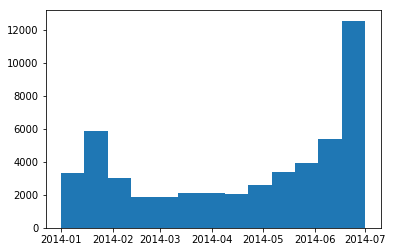

Number of empty entries =  0


In [468]:
# A Rider is considered retained if they used the service withinthe last 30 days.
# Let's Inspect the distribution of the riders' last trip dates.
# Set the number of bins to 13 so we can see the distribution in two week segments
# The last two columns of the histogram will correspond to active riders.

plt.hist(pd.to_datetime(df['last_trip_date']), bins = 13)
plt.show()
print('Number of empty entries = ', df[df['last_trip_date'].isnull()].shape[0])

For the purposes of this exercise, we will assume that engaged drivers have a last dats of service within two weeks of July 1, 2014.

In [469]:
percent_retained= sum(pd.to_datetime(df['last_trip_date']) >= pd.to_datetime('2014-05-31')) / df.shape[0]* 100
print('Percentage of drivers still active within 30 days of of July 1, 2014 =', round(percent_retained, 2), '%')

Percentage of drivers still active within 30 days of of July 1, 2014 = 38.45 %


In [470]:
retained = pd.to_datetime(df['last_trip_date']) >= pd.to_datetime('2014-05-31')

retained_df = df.copy()

retained_df['retained'] = retained

retained_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


## 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

I will build a lightGBM model to address the question, and assess feature importance.  To properly the model, categorical data will need to be converted to numeric format and datetimes will be converted to floats.  

Then, the classifier will be subject to some preliminary training and boosting to determine feature importance using the roc_auc score.  A Null Importances distribution will also be created to assess the likelihood that our feature importance developed from the data set might be due to chance.  We will then visualize how our observed feature importances compare to the null distribution using the roc_auc metric on split and gain scores.

The strongest features will then be selected for building and training the classifier.


In [471]:
# Drop last_trip_date as that will be cheating when training a classifier and the information in this column
#  cannot be easily used for practical purposes.

# Also Drop the signup_date.  In alayses below, it was found that this feature had very little importance,
#  and it will be removed to reduce the amount of poosible noise in the data.

# Resolve the city and phone information into categorical values

cities = pd.get_dummies(retained_df.city)
phones = pd.get_dummies(retained_df.phone)

retained_df = retained_df.drop(['last_trip_date', 'signup_date'], axis = 1)
retained_df = retained_df.drop(['city', 'phone'], axis = 1)
retained_df = retained_df.join(cities, how = 'outer')
retained_df = retained_df.join(phones, how = 'outer')

retained_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,Astapor,King's Landing,Winterfell,Android,iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,True,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,False,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,False,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,True,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,False,0,0,1,1,0


In [472]:
for column in retained_df.columns:
    print('Datatype for ', column, ' column is = ', retained_df[column].dtype)

Datatype for  avg_dist  column is =  float64
Datatype for  avg_rating_by_driver  column is =  float64
Datatype for  avg_rating_of_driver  column is =  float64
Datatype for  avg_surge  column is =  float64
Datatype for  surge_pct  column is =  float64
Datatype for  trips_in_first_30_days  column is =  int64
Datatype for  ultimate_black_user  column is =  bool
Datatype for  weekday_pct  column is =  float64
Datatype for  retained  column is =  bool
Datatype for  Astapor  column is =  uint8
Datatype for  King's Landing  column is =  uint8
Datatype for  Winterfell  column is =  uint8
Datatype for  Android  column is =  uint8
Datatype for  iPhone  column is =  uint8


Let's build a classifier and begin tuning.

In [473]:
# Perform a train-test split and compute initial roc_auc

retained_features = retained_df.copy().drop('retained', axis = 1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(retained_features, retained_df['retained'], random_state=42, test_size=0.3)
lgb_classifier = lgb.LGBMClassifier(random_state = 47, free_raw_data=False, silent=True).fit(Xtrain, Ytrain) 
prediction = lgb_classifier.predict(Xtest)
print('Roc_auc score for default classifier is ', roc_auc_score(Ytest, prediction))


Roc_auc score for default classifier is  0.7653147007148332


In [474]:
def modelfit(alg, dtrain, predictors, target, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.805
AUC Score (Train): 0.877550
CV Score : Mean - 0.8598275 | Std - 0.004119461 | Min - 0.8536839 | Max - 0.864662


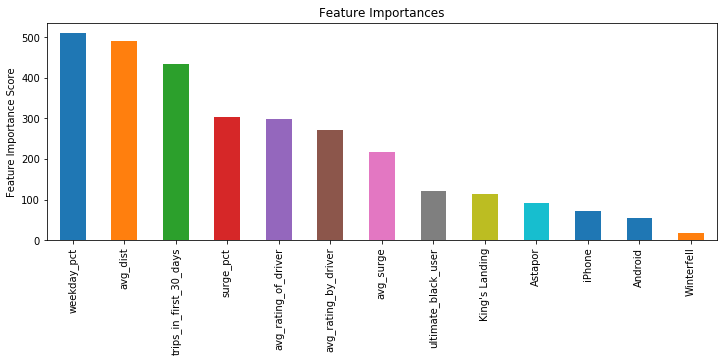

In [475]:
rcParams['figure.figsize'] = 12, 4

target = 'retained'

predictors = [x for x in retained_df.columns if x not in [target]]
lgb0 = lgb.LGBMClassifier(objective = 'binary', random_state = 47)
modelfit(lgb0, retained_df, predictors, target)

In [476]:
param_test1 = {'num_leaves':np.arange(10, 250, 10), 'max_depth':np.arange(4, 8, 1)}
gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier(objective = 'binary', random_state = 47), 
                        param_grid = param_test1, cv=5, return_train_score=True)
gsearch1.fit(retained_df[predictors],retained_df[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_   

({'mean_fit_time': array([0.19712949, 0.21110678, 0.20871143, 0.20871134, 0.20801282,
         0.20901079, 0.21519933, 0.21080761, 0.22827473, 0.21030836,
         0.21070786, 0.21120672, 0.21060796, 0.20970936, 0.21489992,
         0.20931048, 0.21050801, 0.23146887, 0.21120691, 0.20931034,
         0.2125041 , 0.21360235, 0.21180553, 0.21919188, 0.2064158 ,
         0.25342798, 0.24464445, 0.24314704, 0.24314713, 0.2470397 ,
         0.24883666, 0.25482564, 0.24384594, 0.26630416, 0.24713993,
         0.2486372 , 0.25093298, 0.26929855, 0.25053363, 0.26091409,
         0.2717936 , 0.25302877, 0.25143156, 0.28986015, 0.25612297,
         0.25233006, 0.25342817, 0.24783883, 0.22208624, 0.23326564,
         0.26221166, 0.27588634, 0.28646674, 0.29345355, 0.29584894,
         0.31840715, 0.29205599, 0.29515057, 0.29874353, 0.29754577,
         0.29594893, 0.29844398, 0.31231837, 0.29305458, 0.31820731,
         0.30732789, 0.30603004, 0.30323524, 0.33288012, 0.31351604,
         0.302935


Model Report
Accuracy : 0.8062
AUC Score (Train): 0.879849
CV Score : Mean - 0.8593131 | Std - 0.003761636 | Min - 0.8533967 | Max - 0.8638667


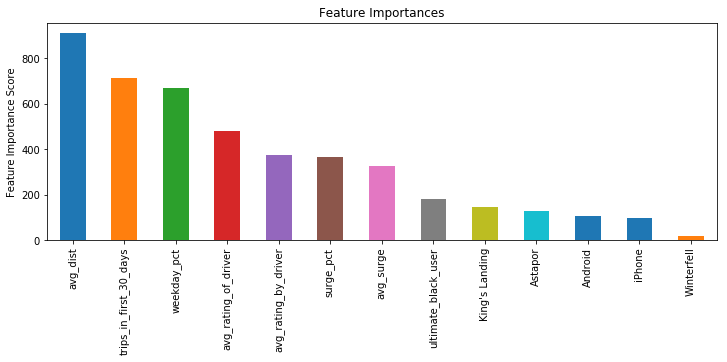

In [477]:
lgbm1 = lgb.LGBMClassifier(objective = 'binary', max_depth = 6, num_leaves = 50, random_state = 47)
modelfit(lgbm1, retained_df, predictors, target)

In [478]:
model1 = lgb.LGBMClassifier(objective = 'binary', max_depth = 6, num_leaves = 50, random_state = 47)
model1.fit(Xtrain, Ytrain)


prediction = model1.predict(Xtest) 
roc_auc_score(Ytest, prediction)

0.7658407785077677

In [479]:
param_test2 = {'min_data_in_leaf':np.arange(150, 300, 25)}
gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(objective = 'binary', random_state = 47, 
                                                        max_depth = 6, num_leaves = 50,), 
                        param_grid = param_test2, cv=5, return_train_score=True)

gsearch2.fit(retained_df[predictors], retained_df[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_ 

({'mean_fit_time': array([0.29475136, 0.31880627, 0.32599306, 0.27029653, 0.2893611 ,
         0.26979742]),
  'std_fit_time': array([0.03072673, 0.04380745, 0.04715841, 0.00378226, 0.02180058,
         0.00297112]),
  'mean_score_time': array([0.0375299 , 0.03942671, 0.03832846, 0.03763008, 0.03932676,
         0.03832884]),
  'std_score_time': array([0.00058214, 0.00104701, 0.00091506, 0.00039923, 0.00193018,
         0.00073331]),
  'param_min_data_in_leaf': masked_array(data=[150, 175, 200, 225, 250, 275],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_data_in_leaf': 150},
   {'min_data_in_leaf': 175},
   {'min_data_in_leaf': 200},
   {'min_data_in_leaf': 225},
   {'min_data_in_leaf': 250},
   {'min_data_in_leaf': 275}],
  'split0_test_score': array([0.78712129, 0.7880212 , 0.78752125, 0.78782122, 0.78912109,
         0.78762124]),
  'split1_test_score': array([0.78792121, 0.78852115, 0.787221


Model Report
Accuracy : 0.8013
AUC Score (Train): 0.874171
CV Score : Mean - 0.8591785 | Std - 0.003954753 | Min - 0.853358 | Max - 0.8639432


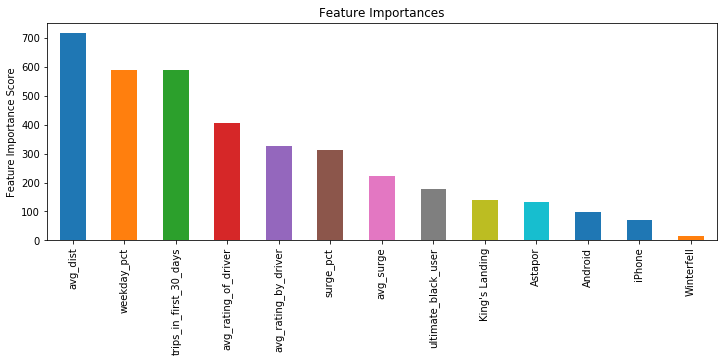

In [480]:
lgbm2 = lgb.LGBMClassifier(objective = 'binary', max_depth = 6, num_leaves = 50, min_data_in_leaf = 175, random_state = 47)
modelfit(lgbm2, retained_df, predictors, target)

In [481]:
model2 = lgb.LGBMClassifier(objective = 'binary', max_depth = 6, num_leaves = 50, min_data_in_leaf = 175, random_state = 47)
model2.fit(Xtrain, Ytrain)


prediction = model2.predict(Xtest) 
roc_auc_score(Ytest, prediction)

0.7631425304033046

In [482]:
param_test3 = {'max_bin':np.arange(200, 1000, 100)}
gsearch3 = GridSearchCV(estimator = lgb.LGBMClassifier(objective = 'binary', random_state = 47, min_data_in_leaf = 175,
                                                        max_depth = 6, num_leaves = 50,), 
                        param_grid = param_test3, cv=5, return_train_score=True)

gsearch3.fit(retained_df[predictors], retained_df[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.27019672, 0.28127589, 0.28596768, 0.29934278, 0.30014105,
         0.33268046, 0.31441441, 0.31341629]),
  'std_fit_time': array([0.00340837, 0.00661772, 0.00534721, 0.01354485, 0.00267064,
         0.03844398, 0.00431626, 0.0058882 ]),
  'mean_score_time': array([0.03802924, 0.04032502, 0.03772979, 0.03772964, 0.03952622,
         0.03902726, 0.03822894, 0.03763008]),
  'std_score_time': array([0.00058167, 0.00277679, 0.00039926, 0.0003996 , 0.00200643,
         0.0024533 , 0.00102746, 0.00024431]),
  'param_max_bin': masked_array(data=[200, 300, 400, 500, 600, 700, 800, 900],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_bin': 200},
   {'max_bin': 300},
   {'max_bin': 400},
   {'max_bin': 500},
   {'max_bin': 600},
   {'max_bin': 700},
   {'max_bin': 800},
   {'max_bin': 900}],
  'split0_test_score': array([0.78952105, 0.78922108, 0.78872113, 0.78982102

In [483]:
param_test4 = {'learning_rate':np.arange(0.001, 0.101, .01), 'num_iterations': np.arange(100, 1000, 100)}
gsearch4 = GridSearchCV(estimator = lgb.LGBMClassifier(objective = 'binary', random_state = 47, min_data_in_leaf = 175,
                                                        max_depth = 6, num_leaves = 50, max_bin = 300), 
                        param_grid = param_test4, cv=5, return_train_score=True)

gsearch4.fit(retained_df[predictors], retained_df[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.33317947, 0.58740597, 0.89124336, 1.13059435, 1.48573308,
         1.70492477, 1.93848972, 2.20359592, 2.46291265, 0.34665446,
         0.61645179, 0.84502625, 1.18389511, 1.46736722, 1.59972072,
         1.69743876, 1.98081079, 2.08162289, 0.32559357, 0.55636373,
         0.81907454, 0.96889758, 1.15584722, 1.32084002, 1.46487179,
         1.67428317, 1.81182542, 0.34006681, 0.59299574, 0.76028366,
         0.93186436, 1.06411791, 1.28011565, 1.57526608, 1.66020756,
         1.99688268, 0.36272392, 0.58820486, 0.7921247 , 0.99185276,
         1.20116482, 1.38781552, 1.56418629, 1.82080865, 1.90385399,
         0.38837686, 0.64729481, 0.91100307, 1.0443552 , 1.06331992,
         1.30337248, 1.447504  , 1.62297802, 1.75602908, 0.35324216,
         0.51064897, 0.68372684, 0.88864532, 1.05653224, 1.3191431 ,
         1.41007395, 1.50819125, 1.71191154, 0.33038478, 0.59578991,
         0.7050868 , 0.82426472, 1.00941973, 1.12929673, 1.31095839,
         1.438820


Model Report
Accuracy : 0.8095
AUC Score (Train): 0.883398
CV Score : Mean - 0.8604771 | Std - 0.003620273 | Min - 0.8544353 | Max - 0.864194


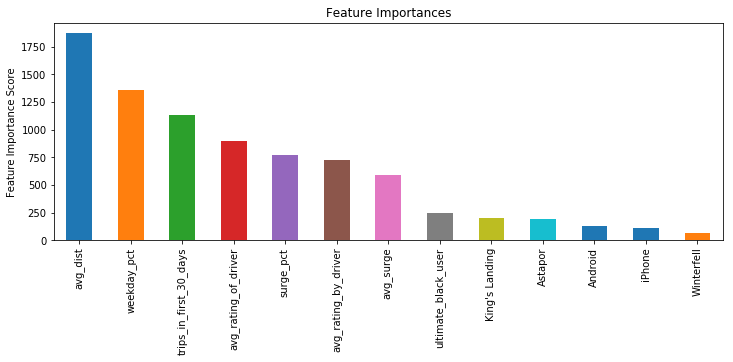

In [484]:
model3 = lgb.LGBMClassifier(objective = 'binary', max_depth = 6, num_leaves = 50, min_data_in_leaf = 250,
                            random_state = 47, max_bin = 800, learning_rate = 0.081, num_iterations = 300
                            )
modelfit(model3, retained_df, predictors, target)

In [485]:
from sklearn.metrics import confusion_matrix

prediction = model3.predict(Xtest) 
roc_auc_score(Ytest, prediction), f1_score(Ytest, prediction), confusion_matrix(Ytest, prediction)

(0.7870802373699153, 0.7354744258395095, array([[8090, 1182],
        [1709, 4019]], dtype=int64))

The tune LightGBM, labeled Model3 in the above analysis shows promise for predictive modeling with a roc_auc score of 0.787.  This number is a score that determines how good the classifier is at separating classes.  A more interpretable metric comes by way of the confusion matrix which shows us the overall accuracy of the classifier on test data is about 81%.


## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Features that indicate the rider will continue using the service (in order of importance) are as follows.

1.  Avg Distance - perhaps because the further a passenger has to go, the less likely public transportation is efficient
2.  Weekday Usage - indicates the users who take the service to and from work have greater longevity
3.  Trips in first 30 days - a more useful feature might be 'trips per month', but this data suggests frequent users stick around
4.  Avg rating of driver - riders who have good experiences with driver continue to use service
5.  Percent Surge + avg surge - riders who depend on our service during peak hours are more likely to use the service
6.  Avg rating by driver - riders who are courteous and professional continue to use the service.

In conclusion we want to do more to promote the "business class" rider.  This is someone who travels on the weekdays, travels often each month, and often during surge hours.  Riders who have positive interactions with drivers are also good long-term prospects.

Could we target businesses which are far from public transportation routes and offer a promotional period where their employees can use our services at a discount?  Can we offer incentives to riders who use our services more than a cerain number of times per month?  

Next steps: Develop pilot programs to attract more riders with high longevity predictions.  Explore other data elements from the original database which may provide insights for when 'business class' riders are likely to discontinue service.  Pilot an intervention/retention program to address these customers. 


